#**DEEP LEARNING - Denoising Autoencoders for Tamil Characters (Blur noise)**


##**Parameshwari S - CB.SC.I5DAS18026**

### **Uploading the data**

In [ ]:
!pip install Wand
!apt-get install libmagickwand-dev

     |████████████████████████████████| 139 kB 4.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common
  libcairo-script-interpreter2 libcairo2-dev libcupsfilters1 libcupsimage2
  libdjvulibre-dev libdjvulibre-text libdjvulibre21 libgdk-pixbuf2.0-dev
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 liblcms2-dev liblqr-1-0
  liblqr-1-0-dev libmagickcore-6-arch-config libmagickcore-6-headers
  libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra libmagickcore-6.q16-dev
  libmagickwand-6-headers libmagickwand-6.q16-3 libmagickwand-6.q16-dev
  libpixman-1-dev librsvg2-dev libwmf-dev libwmf0.2-7 libxcb-shm0-dev
  poppler-data
Suggested packages:
  fonts-noto ghostscript-x libcairo2-doc inkscape libjxr-tools librsvg2-doc
  libwmf-doc libwmf0.2-7-gtk poppler-u

In [ ]:
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

In [ ]:
import zipfile  # unziping 
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
# 1. Unzip images
path = '/content/dataset.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/image_data')

### **Converting images to .jpeg format from .tiff**

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

os.makedirs('/content/jpg_data')

for files in  os.listdir("/content/image_data/shuffled"):
    im = Image.open('/content/image_data/shuffled/'+str(files))
    im.save('/content/jpg_data/'+str(files).replace(".tiff","")+'.jpeg')

###**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from PIL import Image

datagen = ImageDataGenerator(
            width_shift_range=0.2,  
            height_shift_range=0.2,           
            zoom_range=0.2)

image_directory = '/content/55/'
SIZE = 224
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
   if (image_name.split('.')[1] == 'jpg'):        
       image = io.imread(image_directory + image_name)        
       image = Image.fromarray(image, 'RGB')        
       image = image.resize((SIZE,SIZE)) 
       dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/jpg_data/',
                          save_prefix='u55_155t',
                          save_format='jpeg'):    
  i += 1    
  if i > 20:        
     break

###**Resizing all images into the same size**

In [ ]:
os.makedirs('/content/processed_img')

for fil in  os.listdir("/content/jpg_data"):
    img=cv2.imread('/content/jpg_data/'+str(fil))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2=255-img
    img2=cv2.resize(img2, (128, 128))
    cv2.imwrite("/content/processed_img/"+str(fil), img2)

### **Adding Impulse noise**

In [ ]:
from wand.image import Image
os.makedirs("/content/noisy_dataset")
for fil in  os.listdir("/content/processed_img"):
    img = cv2.imread('/content/processed_img/'+str(fil))
    with Image() as img:
      img.read(filename = '/content/processed_img/'+str(fil))
      img.blur(radius=0, sigma=3)
      img.save(filename = '/content/noisy_dataset/'+str(fil))

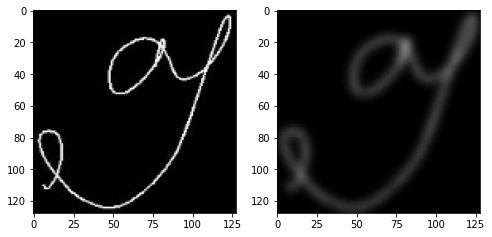

In [ ]:
fig = plt.figure(figsize=(8,5))
img1 = cv2.imread('/content/processed_img/u16_010t09.jpeg')
ax1 = fig.add_subplot(121)
ax1.imshow(img1)
img2 = cv2.imread('/content/noisy_dataset/u16_010t09.jpeg')
ax2 = fig.add_subplot(122)
ax2.imshow(img2)

###**Classifying X and y for train-test split**

In [ ]:
images=[]
noisy_images=[]
for files in os.listdir('/content/processed_img/'):
  img=cv2.imread('/content/processed_img/'+files,0)/255
  img=cv2.resize(img,(128,128))
  img.shape=(128,128,1)
  images.append(img)

for files in os.listdir('/content/noisy_dataset/'):
  img=cv2.imread('/content/noisy_dataset/'+files,0)/255
  img=cv2.resize(img,(128,128))
  img.shape=(128,128,1)
  noisy_images.append(img)
images=np.array(images)
noisy_images=np.array(noisy_images)

### **Train test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(noisy_images, images, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1164, 128, 128, 1)

In [ ]:
len(X_train)

1164

In [ ]:
len(X_test)

291

###**Denoising Autoencoder**

In [ ]:
input_img = keras.Input(shape=(128, 128, 1))
#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)

#decoder
conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv3)
up1 = UpSampling2D((2,2))(conv4)
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2,2))(conv5)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 8)         1160

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,batch_size=75)

Epoch 1/10
16/16 [==============================] - 38s 2s/step - loss: 0.6604 - accuracy: 0.6170 - val_loss: 0.5749 - val_accuracy: 0.6531
Epoch 2/10
16/16 [==============================] - 38s 2s/step - loss: 0.4551 - accuracy: 0.6532 - val_loss: 0.3812 - val_accuracy: 0.6531
Epoch 3/10
16/16 [==============================] - 38s 2s/step - loss: 0.3247 - accuracy: 0.6532 - val_loss: 0.2714 - val_accuracy: 0.6531
Epoch 4/10
16/16 [==============================] - 38s 2s/step - loss: 0.2409 - accuracy: 0.6532 - val_loss: 0.2109 - val_accuracy: 0.6531
Epoch 5/10
16/16 [==============================] - 38s 2s/step - loss: 0.1914 - accuracy: 0.6532 - val_loss: 0.1721 - val_accuracy: 0.6531
Epoch 6/10
16/16 [==============================] - 37s 2s/step - loss: 0.1615 - accuracy: 0.6532 - val_loss: 0.1533 - val_accuracy: 0.6531
Epoch 7/10
16/16 [==============================] - 37s 2s/step - loss: 0.1478 - accuracy: 0.6532 - val_loss: 0.1437 - val_accuracy: 0.6531
Epoch 8/10
16/16 [==

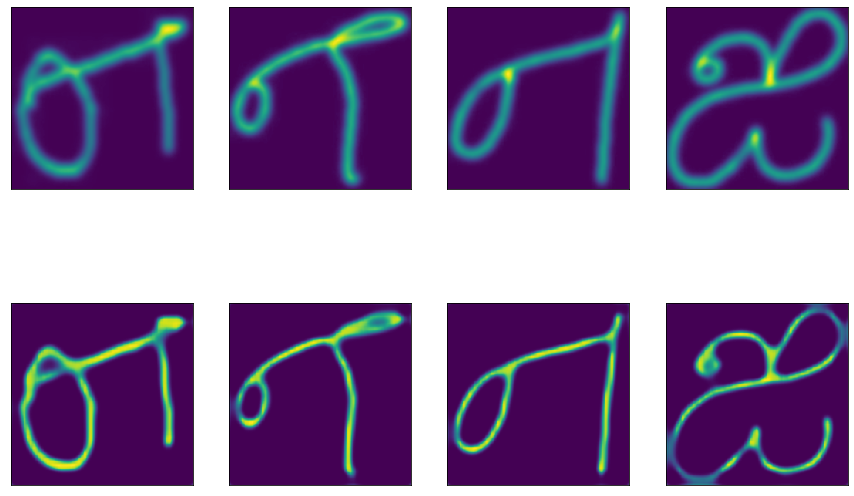

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

Epoch 1/20
12/12 [==============================] - 36s 3s/step - loss: 0.6236 - accuracy: 0.6493 - val_loss: 0.4688 - val_accuracy: 0.6531
Epoch 2/20
12/12 [==============================] - 35s 3s/step - loss: 0.3905 - accuracy: 0.6532 - val_loss: 0.3229 - val_accuracy: 0.6531
Epoch 3/20
12/12 [==============================] - 35s 3s/step - loss: 0.2783 - accuracy: 0.6532 - val_loss: 0.2387 - val_accuracy: 0.6531
Epoch 4/20
12/12 [==============================] - 35s 3s/step - loss: 0.2196 - accuracy: 0.6532 - val_loss: 0.1993 - val_accuracy: 0.6531
Epoch 5/20
12/12 [==============================] - 35s 3s/step - loss: 0.1841 - accuracy: 0.6532 - val_loss: 0.1700 - val_accuracy: 0.6531
Epoch 6/20
12/12 [==============================] - 35s 3s/step - loss: 0.1617 - accuracy: 0.6532 - val_loss: 0.1566 - val_accuracy: 0.6531
Epoch 7/20
12/12 [==============================] - 35s 3s/step - loss: 0.1528 - accuracy: 0.6532 - val_loss: 0.1510 - val_accuracy: 0.6531
Epoch 8/20
12/12 [==

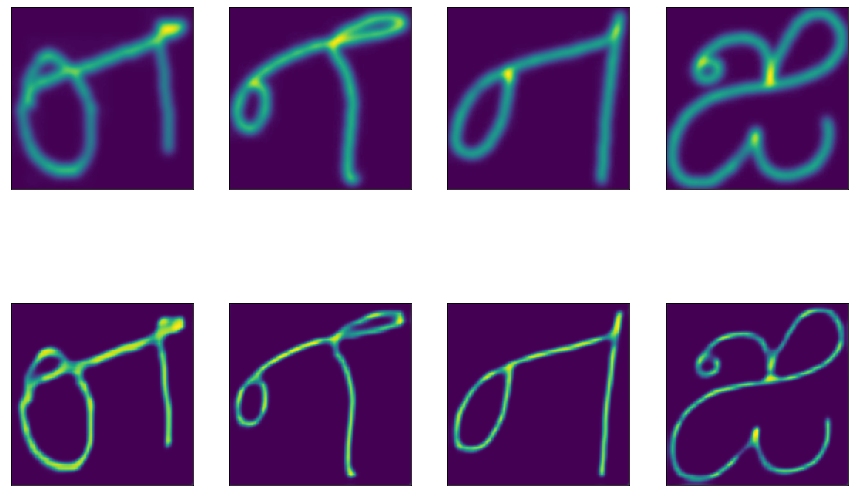

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=75)

Epoch 1/25
16/16 [==============================] - 38s 2s/step - loss: 0.6325 - accuracy: 0.6312 - val_loss: 0.4840 - val_accuracy: 0.6531
Epoch 2/25
16/16 [==============================] - 38s 2s/step - loss: 0.4125 - accuracy: 0.6532 - val_loss: 0.3307 - val_accuracy: 0.6531
Epoch 3/25
16/16 [==============================] - 38s 2s/step - loss: 0.2646 - accuracy: 0.6532 - val_loss: 0.1962 - val_accuracy: 0.6531
Epoch 4/25
16/16 [==============================] - 38s 2s/step - loss: 0.1727 - accuracy: 0.6532 - val_loss: 0.1574 - val_accuracy: 0.6531
Epoch 5/25
16/16 [==============================] - 38s 2s/step - loss: 0.1488 - accuracy: 0.6532 - val_loss: 0.1420 - val_accuracy: 0.6531
Epoch 6/25
16/16 [==============================] - 39s 2s/step - loss: 0.1352 - accuracy: 0.6534 - val_loss: 0.1291 - val_accuracy: 0.6544
Epoch 7/25
16/16 [==============================] - 39s 2s/step - loss: 0.1227 - accuracy: 0.6555 - val_loss: 0.1178 - val_accuracy: 0.6561
Epoch 8/25
16/16 [==

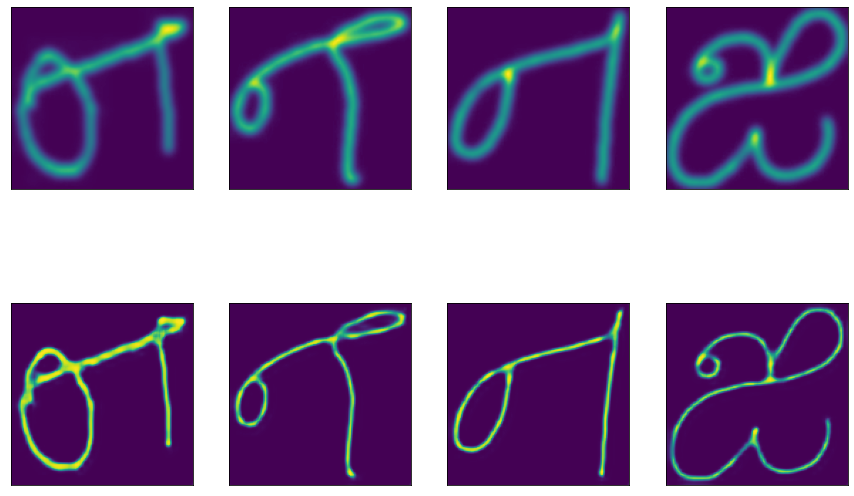

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40,batch_size=100)

Epoch 1/40
12/12 [==============================] - 37s 3s/step - loss: 0.6261 - accuracy: 0.6412 - val_loss: 0.4740 - val_accuracy: 0.6531
Epoch 2/40
12/12 [==============================] - 38s 3s/step - loss: 0.4140 - accuracy: 0.6532 - val_loss: 0.3330 - val_accuracy: 0.6531
Epoch 3/40
12/12 [==============================] - 37s 3s/step - loss: 0.2913 - accuracy: 0.6532 - val_loss: 0.2465 - val_accuracy: 0.6531
Epoch 4/40
12/12 [==============================] - 37s 3s/step - loss: 0.2249 - accuracy: 0.6532 - val_loss: 0.2028 - val_accuracy: 0.6531
Epoch 5/40
12/12 [==============================] - 37s 3s/step - loss: 0.1875 - accuracy: 0.6532 - val_loss: 0.1714 - val_accuracy: 0.6531
Epoch 6/40
12/12 [==============================] - 37s 3s/step - loss: 0.1595 - accuracy: 0.6532 - val_loss: 0.1504 - val_accuracy: 0.6531
Epoch 7/40
12/12 [==============================] - 37s 3s/step - loss: 0.1440 - accuracy: 0.6532 - val_loss: 0.1402 - val_accuracy: 0.6531
Epoch 8/40
12/12 [==

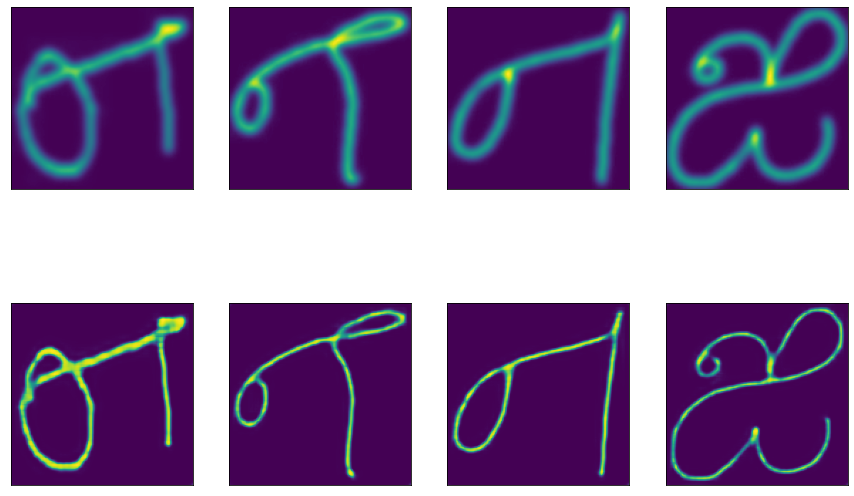

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,batch_size=75)

Epoch 1/50
16/16 [==============================] - 37s 2s/step - loss: 0.5853 - accuracy: 0.6457 - val_loss: 0.3956 - val_accuracy: 0.6531
Epoch 2/50
16/16 [==============================] - 35s 2s/step - loss: 0.3460 - accuracy: 0.6532 - val_loss: 0.2707 - val_accuracy: 0.6531
Epoch 3/50
16/16 [==============================] - 35s 2s/step - loss: 0.2316 - accuracy: 0.6532 - val_loss: 0.1960 - val_accuracy: 0.6531
Epoch 4/50
16/16 [==============================] - 35s 2s/step - loss: 0.1763 - accuracy: 0.6532 - val_loss: 0.1607 - val_accuracy: 0.6531
Epoch 5/50
16/16 [==============================] - 36s 2s/step - loss: 0.1534 - accuracy: 0.6532 - val_loss: 0.1488 - val_accuracy: 0.6531
Epoch 6/50
16/16 [==============================] - 36s 2s/step - loss: 0.1439 - accuracy: 0.6532 - val_loss: 0.1403 - val_accuracy: 0.6531
Epoch 7/50
16/16 [==============================] - 36s 2s/step - loss: 0.1346 - accuracy: 0.6532 - val_loss: 0.1291 - val_accuracy: 0.6537
Epoch 8/50
16/16 [==

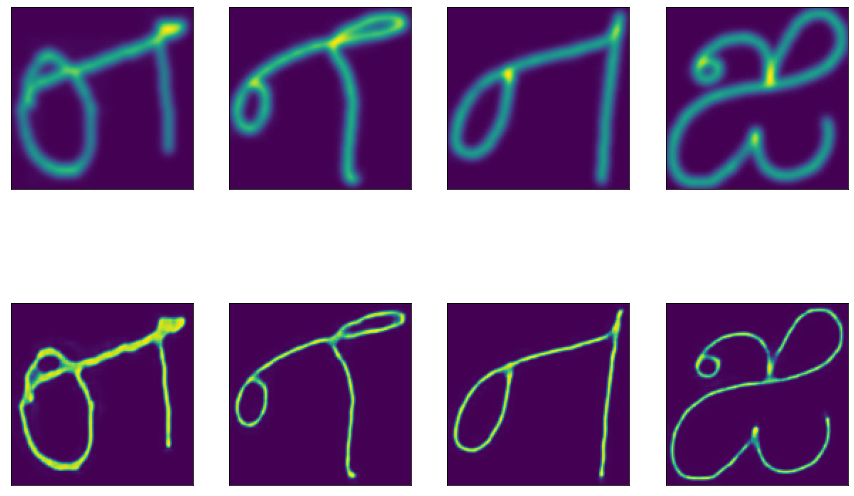

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()